## Windstorm Gloria January 2020

In this notebook we are showing how to get the data and plot different meteorological parameters from ECMWF IFS model using Metview Python library.  

We are downloading data from MARS archive using ecCharts function, which will download data and calculate if anything needs calculated to be presented in the same way the parameter is displayed in ecCharts. This allows comparison with daily forecast. 

In [1]:
import numpy as np
import pandas as pd
import metview as mv
from datetime import datetime, timedelta,date,time
import math

mv.setoutput('jupyter')

### Analyses fields: MSLP with total precipitation and temperature at 850 hPa with geopotential height at 500 hPa plots

We will plot MSLP with total precipitation and temperature at 850 hPa with geopotential height at 500 hPa.  

First we need to define the dates and times for our plots.

In [7]:
start_date = datetime(2020,1,18)
start_step = 0
end_step = 84
step_interval = 12
start_time = 0

steps = [step_begin,'to',step_end,'by',step_interval]

N_frames = (step_end - step_begin)//step_interval

Defining the look of our plots. We will plot them either in 2 or 3 columns.  
We define the look of coastlines and the area here so it can be used later.

In [3]:
col_num_europe = 2
col_num_spain  = 3
row_num_europe = math.ceil(N_frames/col_num_europe)

area_spain  = [30,-15,50,15]
area_europe = [20,-30,60,30]

coastlines = mv.mcoast(
    map_coastline_style             = "solid",
    map_coastline_colour            = "tan",
    map_coastline_resolution        = "high",
    map_coastline_land_shade        = "on",
    map_coastline_land_shade_colour = "cream",
    map_grid                        = "on",
    map_grid_colour                 = "tan",
    map_grid_latitude_increment     = 5.00,
    map_grid_longitude_increment    = 10.00,
    map_grid_line_style             = "dash",
    map_label                       = "on",
    map_label_colour                = "charcoal",
    map_label_height                = 0.35,
    map_label_latitude_frequency    = 2,
    map_label_longitude_frequency   = 2,
    map_label_blanking              = "off"
    )

europe = mv.geoview(
    map_projection      = "cylindrical",
    map_area_definition = "corners",
    coastlines          = coastlines,
    area                = area_europe,
    subpage_clipping    = "on"
    )

spain = mv.geoview(
    map_projection      = "cylindrical",
    map_area_definition = "corners",
    coastlines          = coastlines,
    area                = area_spain,
    subpage_clipping    = "on"
    )

Total precipitation and mean sea level pressure plotted in two columns.  

Analysis time for the MSLP is plotted together with first 6 hours of total precipitation every 12 hours from 18 to 21 January 2020.

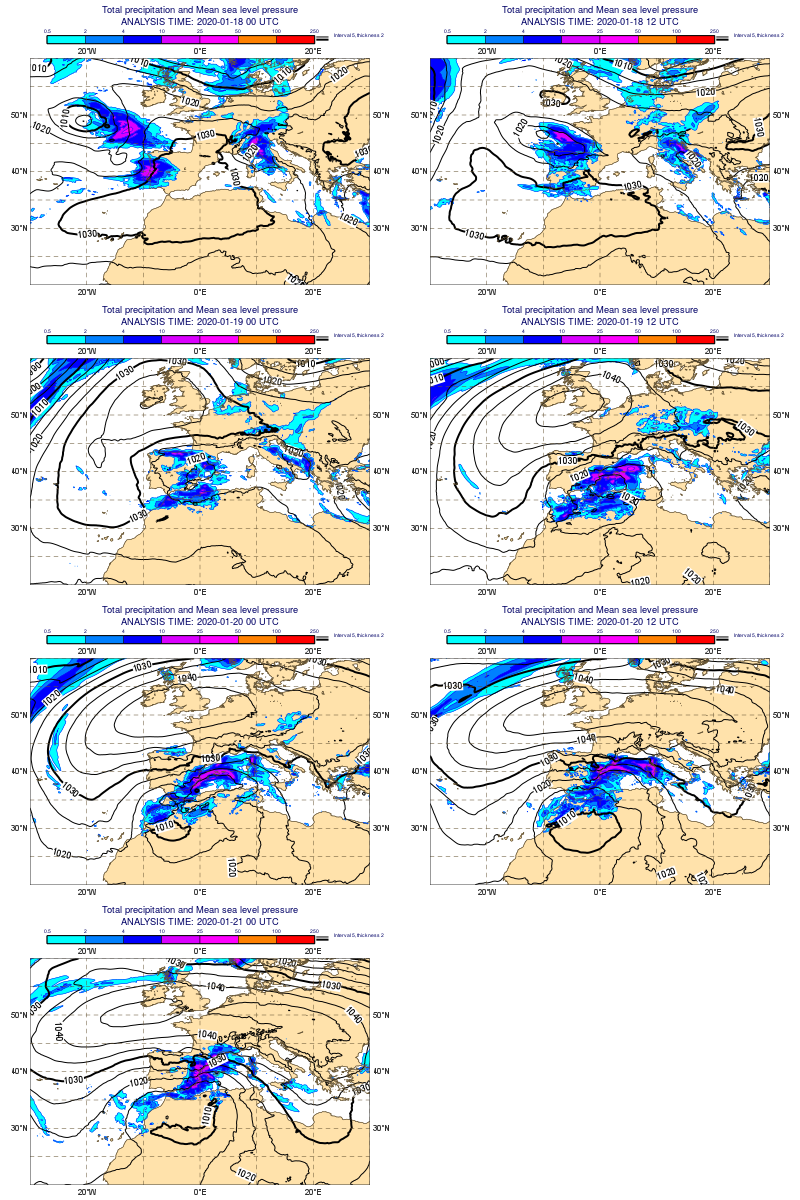

In [11]:
plot_list = []

dw_europe = mv.plot_superpage(
                       pages = mv.mvl_regular_layout(europe,col_num_europe,row_num_europe,1,1),
                       layout_size     = "custom",
                       custom_width    = 32,
                       custom_height   = row_num_europe*12)

for step in range(start_step,end_step,12):
    an_date = start_date + timedelta(hours=step)
    tp = mv.eccharts(
        layer = "tp_interval",
        date  = an_date,
        time  = an_date.hour,
        step  = [0,6],
        grid  = [0.1,0.1]
        )
    msl = mv.eccharts(
        layer = "msl",
        date  = an_date,
        time  = an_date.hour,
        step  = 0,
        grid  = [0.1,0.1]
    )
    
    i = step//12
    
    name1 = mv.grib_get(tp[0], ['name'])[0][0]
    name2 = mv.grib_get(msl[0], ['name'])[0][0]

    title_tp = mv.mtext(text_font_size      = 0.4,
                        text_lines = [name1 + " and " + name2,
                                      "ANALYSIS TIME: <grib_info key='start-date' format='%Y-%m-%d %H UTC' where='shortName=msl'/>"])

    plot_list.extend([dw_europe[i],tp[0][1],tp[1],msl[0][0],msl[1],title_tp])
mv.plot(plot_list)

Analyses fields of temperature at 850 hPa and geopotential height at 500 hPa for the same time period.

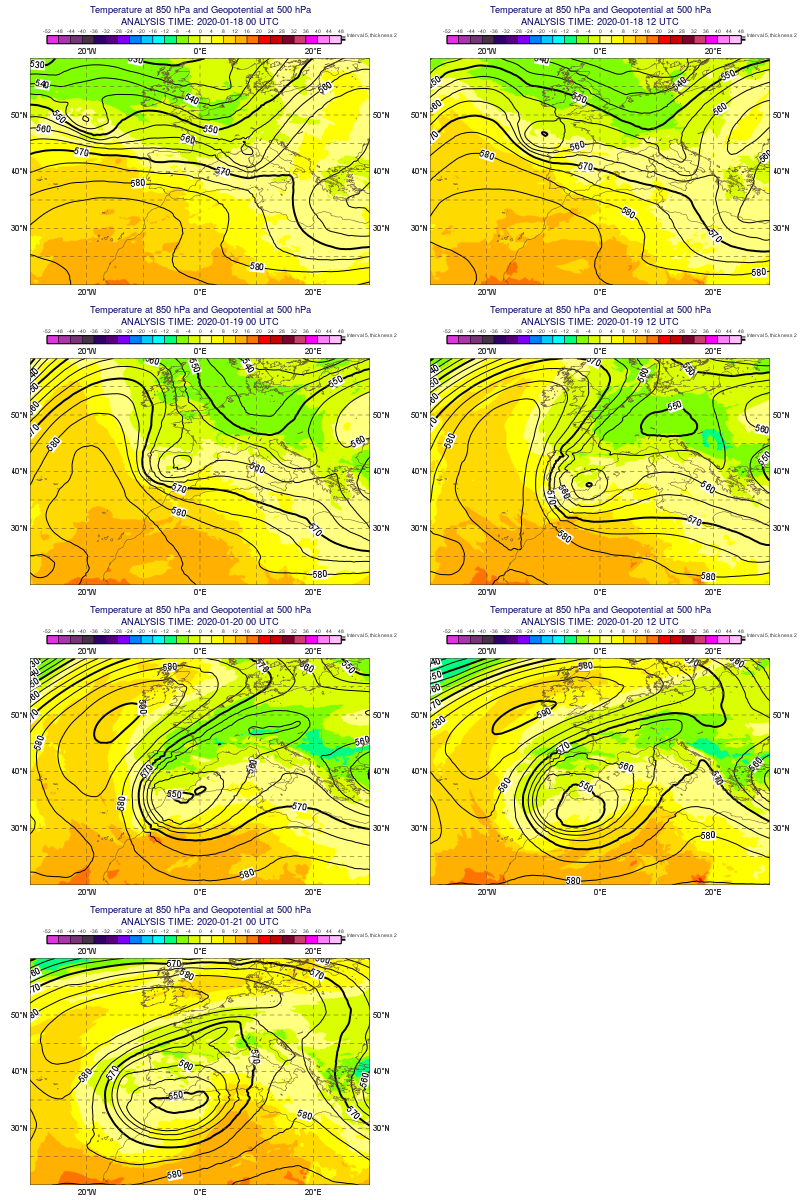

In [12]:
start_date = datetime(2020,1,18)
start_step = 0
end_step = 84

plot_list = []

N_frames = (end_step - start_step)//12

col_num_europe = 2
row_num_europe = math.ceil(N_frames/col_num_europe)

dw_europe = mv.plot_superpage(
                       pages = mv.mvl_regular_layout(europe,col_num_europe,row_num_europe,1,1),
                       layout_size     = "custom",
                       custom_width    = 32,
                       custom_height   = row_num_europe*12)

for step in range(start_step,end_step,12):
    an_date = start_date + timedelta(hours=step)
    t850 = mv.eccharts(
        layer = "t850_field",
        date  = an_date,
        time  = an_date.hour,
        step  = 0,
        grid  = [0.1,0.1]
        )
    z500 = mv.eccharts(
        layer = "z500_field",
        date  = an_date,
        time  = an_date.hour,
        step  = 0,
        grid  = [0.1,0.1]
    )
    
    i = step//12
    
    name_level1 = mv.grib_get(t850[0], ['name','level'])[0]
    name_level2 = mv.grib_get(z500[0], ['name','level'])[0]

    title = mv.mtext(text_font_size      = 0.4,
                 text_lines = [name_level1[0] + " at " + name_level1[1] +  " hPa and " + name_level2[0]  + " at " + name_level2[1] + " hPa",
                               "ANALYSIS TIME: <grib_info key='valid-date' format='%Y-%m-%d %H UTC' where='shortName=t'/>"])

    plot_list.extend([dw_europe[i],t850,z500,title])
mv.plot(plot_list)

### Wind gusts observations 
We will get the observation data for 24 hours from 20 January 2020 to 21 January 2020 at 00 UTC, filter wind gusts and calculate maximum wind gusts for this 24 hours period.

In [13]:
vdate = datetime(2020,1,20) #Start date of validation period
vtime = 0                   #Start time of validation period
vlen = 24                   #Validation period

pd_vdate = vdate + timedelta(hours=vtime)

Getting the observation data

In [14]:
obs1 = mv.retrieve(
            type ="ob",
            repres = "bu",
            obstype = ["sa","sa2","s","s2","bss","bs","bs2"],
            date = pd_vdate,
            time = vtime,
            area = area_spain,
            range = 60*vlen,
            resol = ""
)

obs_filt = mv.obsfilter(
            output = "geopoints",
            parameter = 11041,   #Parameter for wind gusts
            data = obs1
)

We convert filtered observations to pandas dataframe in order to calculate the maximum wind gusts for each point.

In [15]:
df_obs = obs_filt.to_dataframe()

df_group = df_obs.groupby(["latitude","longitude"]).max()

In order to be plotted, pandas dataframe columns are given to the **input_visualiser**.  
We also need to define title and style for symbol plotting.  
These observations will be plotted together with wind gusts from deterministic forecast.

In [16]:
obs_max =mv.input_visualiser(
        input_plot_type        = "geo_points",
        input_longitude_values = df_group.index.to_frame().longitude.tolist(),
        input_latitude_values  = df_group.index.to_frame().latitude.tolist(),
        input_values           = df_group["value"].tolist()  
    )

In [17]:
cl_blue =['rgb(220,235,216)', 'rgb(168,207,204)', 'rgb(128,177,187)', 
          'rgb(96,146,169)',  'rgb(70,116,150)',  'rgb(49,86,129)', 
          'rgb(29,57,109)', 'rgb(8,29,88)']
cl_tran =['rgba(220,235,216,0.5)', 'rgba(168,207,204,0.6)', 'rgba(128,177,187,0.7)', 
          'rgba(96,146,169,0.8)',  'rgba(70,116,150,0.8)',  'rgba(49,86,129,0.9)', 
          'rgba(29,57,109,0.95)', 'rgba(8,29,88,1)']

symbol_plotting = mv.msymb(
    legend                                 = 'on',
    symbol_type                            = "marker",
    symbol_outline                         = "on",
    symbol_outline_colour                  = "#081d58",
    symbol_table_mode                      = "advanced",
    symbol_advanced_table_height_method    = "list",
    symbol_advanced_table_height_list      = [0.6],
    symbol_advanced_table_selection_type   = "list",
    symbol_advanced_table_level_list       = [10,15,20,25,30,40,50,60,70],
    symbol_advanced_table_colour_method    = 'list',
    symbol_advanced_table_colour_list      = cl_tran
    )


wind_gust_shade = mv.mcont(contour = "off", 
                           legend  = "on",
           contour_hilo = "off", 
           contour_label = "off", 
           contour_level_list = [10, 15, 20, 25, 30, 40, 50, 60, 70],
           contour_level_selection_type = "level_list", 
           contour_min_level = 10, 
           contour_shade = "on", 
           contour_shade_colour_method = 'list',
           contour_shade_colour_list = cl_blue,
           contour_shade_method = "area_fill", )

title_wg_obs = mv.mtext(text_font_size      = 0.5,
                        text_lines = ["Observations of 24-hour maximum wind gusts", 
                                      "Valid 20 January 00UTC to 21 January 00UTC"])


### Wind gusts forecast

Wind gusts deterministic forecast data is plotted for the same valid date with different start date and time.  
In order to have the same period as observations, we plot data for 24 hours interval between 00 UTC on 20 January and 21 January 2020. This is why valid date is set at 21 January 2020, at the end of the period.

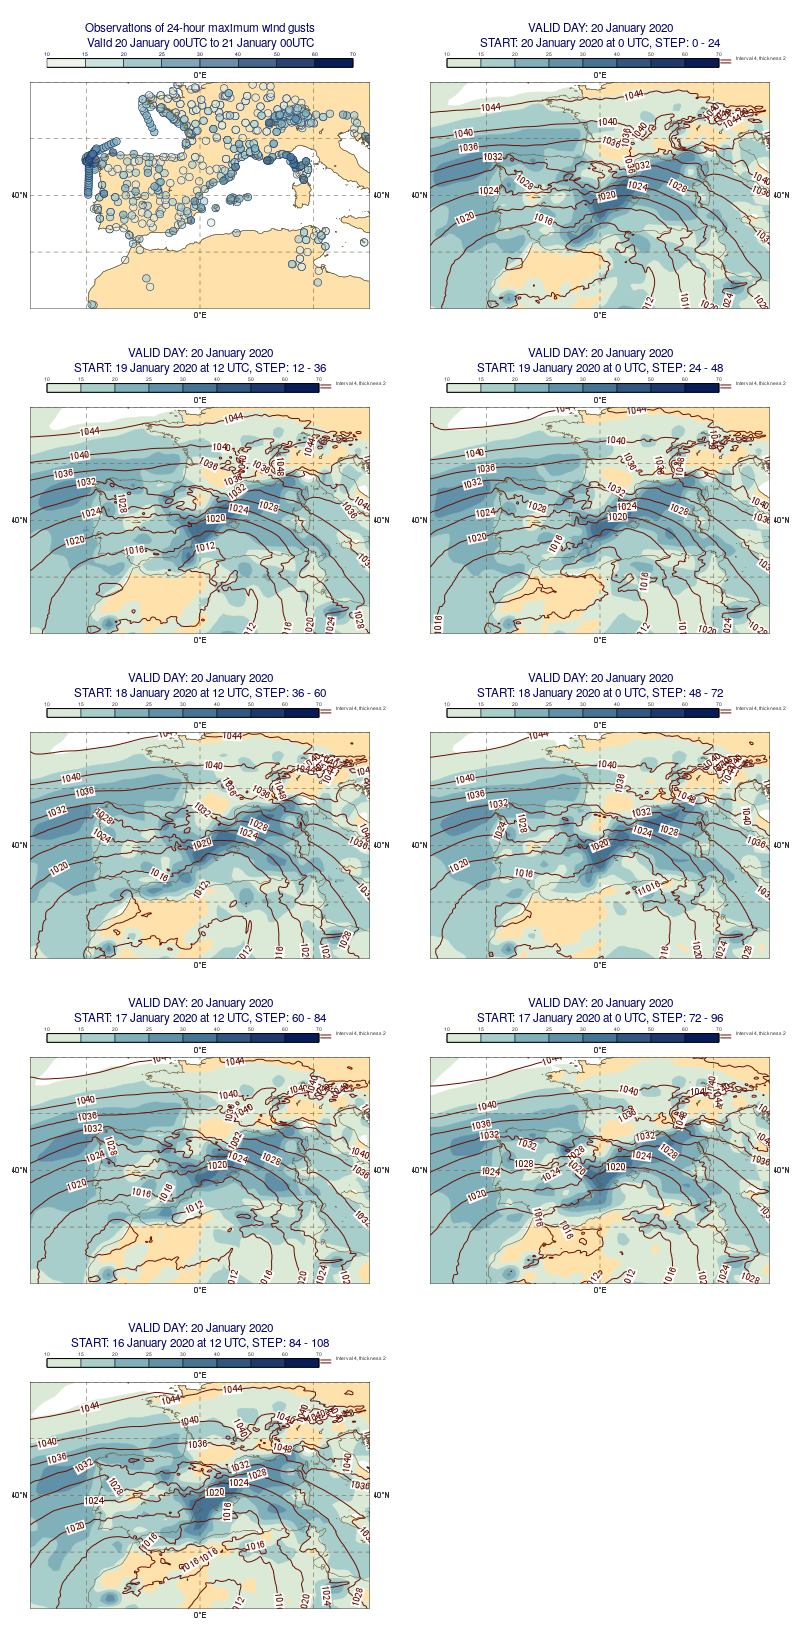

In [18]:

title_wg = mv.mtext(text_font_size      = 0.4,
                    text_lines = ["<grib_info key='name'/>",
                                  " VALID TIME: <grib_info key='valid-date' format='%Y-%m-%d %H UTC' where='shortName=10fg'/> at STEP <grib_info key='step' where='shortName=10fg'/>"])

valid_day = datetime(2020,1,21)

start_step = 24
end_step = 120
frame_N = (end_step - start_step)//12 + 1

col_num_spain = 2
row_num_spain = math.ceil((frame_N)/col_num_spain)

dw_spain = mv.plot_superpage(
                       pages = mv.mvl_regular_layout(spain,col_num_spain,row_num_spain,1,1),
                       layout_size     = "custom",
                       custom_width    = 32,
                       custom_height   = row_num_spain*13)

plot_list = [dw_spain[0],obs_max,symbol_plotting,title_wg_obs] #Plot starts with the observations

for step in range(start_step,end_step,12):
    d = timedelta(hours=step)
    start_date = valid_day - d
    start_time = start_date.hour

    wind_gusts = mv.eccharts(
        layer    = "10m_fg_interval",
        date     = start_date,
        time     = start_time,
        step     = step,
        interval = 24
    )
    mslp = mv.eccharts(
        layer = "msl",
        style = "ct_brn_i4_t2",
        date  = start_date,
        time  = start_time,
        step  = step,
        grid  = [0.1,0.1]
    )
    
    i = step//12-1
    
    title_date = mv.grib_get(wind_gusts[0], ['validityDate','validityTime'])[0]

    valid_date = datetime.strptime(title_date[0], '%Y%m%d')
    valid_time = int(title_date[1])
    date_title = valid_date + timedelta(hours=valid_time) - timedelta(hours=24)
    date_string = date_title.strftime("%d %B %Y")
    start_date = start_date.strftime("%d %B %Y")
    
    title = mv.mtext(text_font_size      = 0.5,
                     text_lines = ["VALID DAY: " + date_string, 
                                    "START: " + start_date + " at " + str(start_time) + " UTC, STEP: " + str(step-24) + " - " + str(step)])
    
    plot_list.extend([dw_spain[i],wind_gusts[0],wind_gust_shade,mslp,title])
    
mv.plot(plot_list)    


We are only plotting one time for Significant wave.

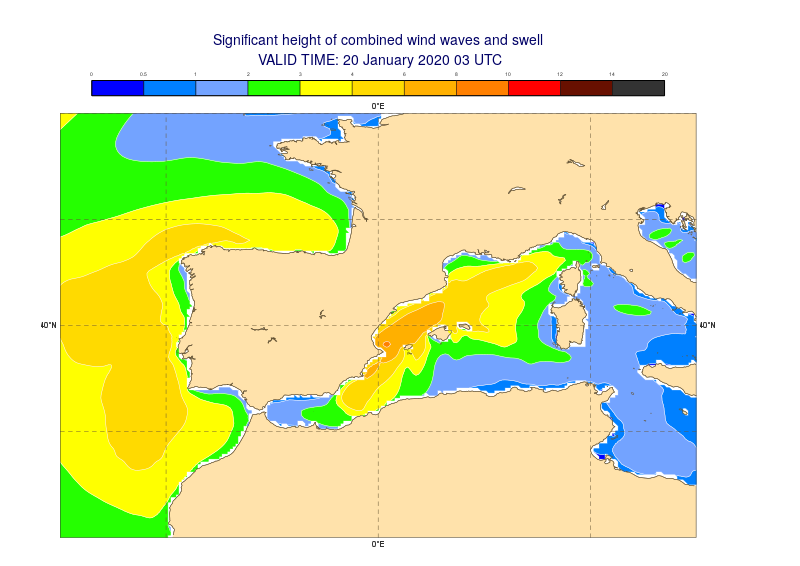

In [19]:
start_date = datetime(2020,1,20)
start_time = 0
step =3
sig_wawe_height = mv.eccharts(
        layer = "wave_swh",
        date  = start_date,
        time  = start_time,
        step  = step,
        grid  = [0.1,0.1]
    )

date_title = start_date + timedelta(hours=step)
date_time  = date_title.strftime("%d %B %Y %H UTC")

title = mv.mtext(text_font_size      = 0.6,
                 text_lines = ["<grib_info key='name'/>",
                               " VALID TIME: " + date_time])
    
mv.plot(spain,sig_wawe_height,title) 

### EFI and SOT

EFI and SOT settings, that are used both for total precipitation and wind gusts index.  
Valid date is the end of the 24 hour period too. So for data at 20 January, valid date is 21 January 2020.

In [20]:
valid_day = datetime(2020,1,21)
start_time = 0

start_step = 24
end_step = 192

frame_N = (end_step - start_step)//24

col_num_spain = 3
row_num_spain = math.ceil((frame_N)/col_num_spain)

dw_spain_efi = mv.plot_superpage(
                       pages = mv.mvl_regular_layout(spain, col_num_spain, row_num_spain, 1, 1),
                       layout_size     = "custom",
                       custom_width    = 32,
                       custom_height   = row_num_spain*9)


###  Wind gusts EFI and SOT index

This can be wrapped in function... Just a thought..

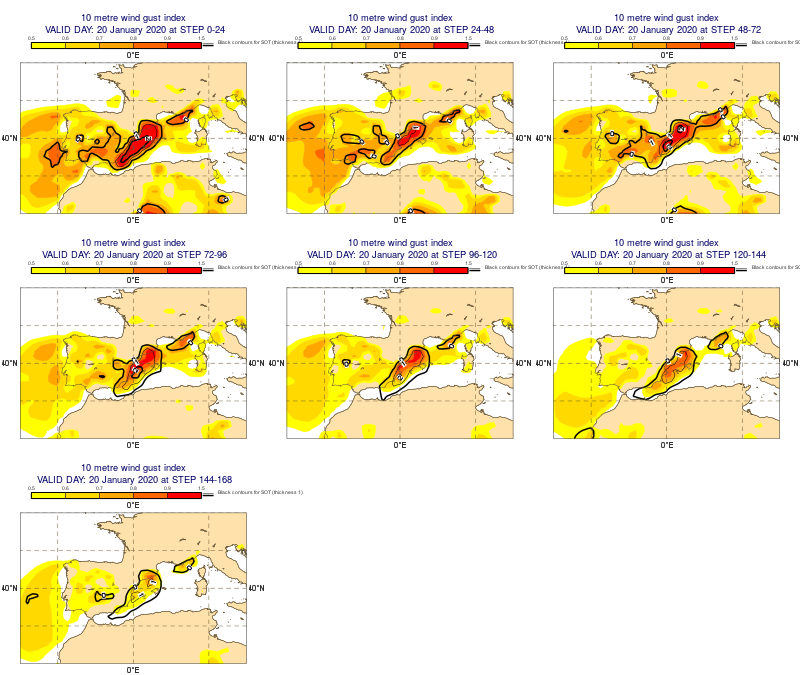

In [21]:
plot_list = []

for step in range(start_step,end_step,24):
    step_str = str(step-24)+'-'+str(step)
    d = timedelta(hours=step)
    start_date = valid_day - d

    efi_eccharts = mv.eccharts(
        layer = "efi_wg_field",
        style = "sh_efi_f05t1_nc",
        date  = start_date,
        time  = start_time,
        step  = step_str
    )
        
    sot_eccharts = mv.eccharts(
        layer = "sot_wg_n90",
        date  = start_date,
        time  = start_time,
        step  = step_str
    )    
    
    i = step//24-1
    
    date_title = start_date + timedelta(hours=step-24)
    date_time  = date_title.strftime("%d %B %Y")
    
    title_efi = mv.mtext(text_font_size = 0.4,
                         text_lines = ["<grib_info key='name'  where='type=efi'/>",
                                     " VALID DAY: " + date_time + " at STEP <grib_info key='step' where='type=efi'/>"])

    
    plot_list.extend([dw_spain_efi[i], efi_eccharts, sot_eccharts, title_efi])
    
    
mv.plot(plot_list) 


### Total precipitation EFI & SOT index

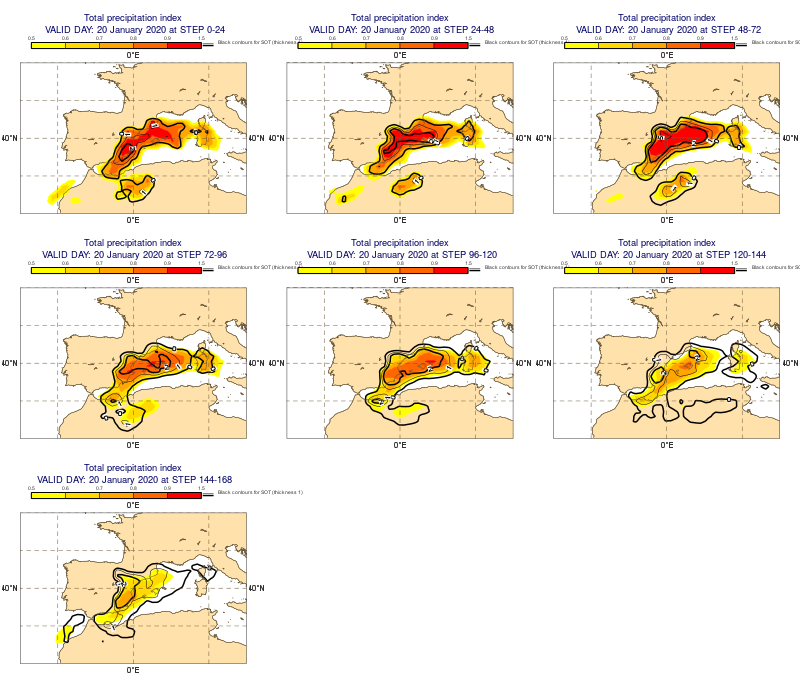

In [22]:
plot_list = []

for step in range(start_step,end_step,24):
    step_str = str(step-24)+'-'+str(step)
    d = timedelta(hours=step)
    start_date = valid_day - d    

    efi_eccharts = mv.eccharts(
        layer = "efi_tp_field",
        style = "sh_efi_f05t1_nc",
        date  = start_date,
        time  = start_time,
        step  = step_str
    )
        
    sot_eccharts = mv.eccharts(
        layer = "sot_tp_n90",
        date  = start_date,
        time  = start_time,
        step  = step_str
    )    
    
    i = step//24-1

    date_title = start_date + timedelta(hours=step-24)
    date_time  = date_title.strftime("%d %B %Y")
    
    title_efi = mv.mtext(text_font_size = 0.4,
                         text_lines = ["<grib_info key='name'  where='type=efi'/>",
                                     " VALID DAY: " + date_time + " at STEP <grib_info key='step' where='type=efi'/>"])
    
    plot_list.extend([dw_spain_efi[i],efi_eccharts,sot_eccharts,title_efi])
    

    
mv.plot(plot_list) 

I wanted to add code to get wms images from eumetsat, but its only good for two weeks.. So either put the code here and write it won't work, but just to use it when making the original content.  

Simulated satelite image is what is missing.

![alt text](myimage.gif)

### Simulated satellite images
Here we plot simulated satellite data every 6 hours on 20 January 2020 (start is 20 January at 00 UTC)

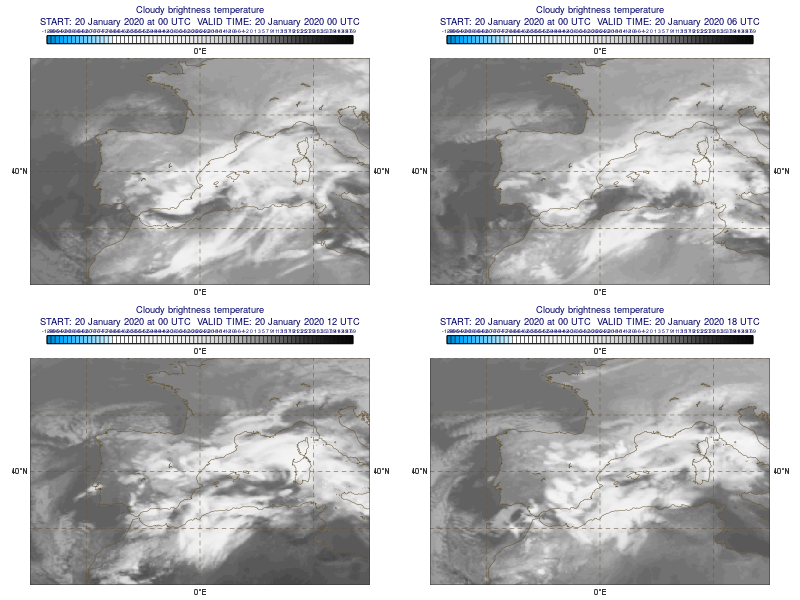

In [23]:
start_date = date(2020,1,20)
start_date_str = start_date.strftime("%d %B %Y")
start_step = 0
end_step = 23
steps = [start_step,'to',end_step,'by',6]

frame_N = (end_step - start_step)/6

col_num_spain = 2
row_num_spain = math.ceil((frame_N)/col_num_spain)

dw_spain_sat = mv.plot_superpage(
                       pages = mv.mvl_regular_layout(spain, col_num_spain, row_num_spain, 1, 1),
                       layout_size     = "custom",
                       custom_width    = 32,
                       custom_height   = row_num_spain*12)

title_sat = mv.mtext(text_font_size = 0.4,
                     text_lines = ["<grib_info key='name'/>",
                                   "START: " + start_date_str + " at 00 UTC  VALID TIME: <grib_info key='valid-date' format='%d %B %Y %H UTC'/>"])

sim_sat   = mv.eccharts(
    layer = "sim_image_ir",
    date  = start_date,
    time  = start_step,
    step  = [0,'to',23,'by',6],
    grid  = [0.1,0.1]
    )
plot_list = []

for i in range(int(mv.count(sim_sat[0]))):
    plot_list.extend([dw_spain_sat[i],sim_sat[0][i],sim_sat[1],title_sat])
    
mv.plot(plot_list)